Lab #4

In [2]:
# Подберите парамтеры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.
# Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.
# Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

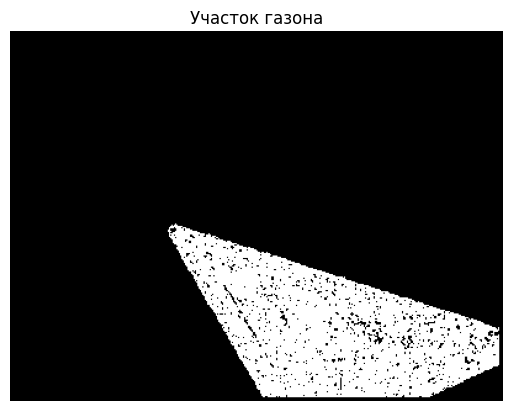

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math
import copy
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) 
def homo_average(img, mask, point, T):
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0])                                       
    if abs(av_val - img[point]) <= T:
        return True
    return False
def region_growing(image, seed_point, homo_fun, r, T):
    mask = np.zeros(image.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image.shape, np.uint8)
        for i in range(r, image.shape[0] - r):
            for j in range(r, image.shape[1] - r):
                if mask[i, j] == 0 and mask[i - r:i + r, j - r:j + r].sum() > 0:
                    if homo_fun(image, mask, (i, j), T):
                        local_mask[i, j] = 1
        count = np.count_nonzero(local_mask)
        mask += local_mask
    return mask * 255
seed_point = (250, 250)
r = 3
T = 15
mask = region_growing(image_gray, seed_point, homo_average, r, T)
plt.imshow(mask, cmap="gray")
plt.title("Участок газона")
plt.axis('off')
plt.show()

Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.

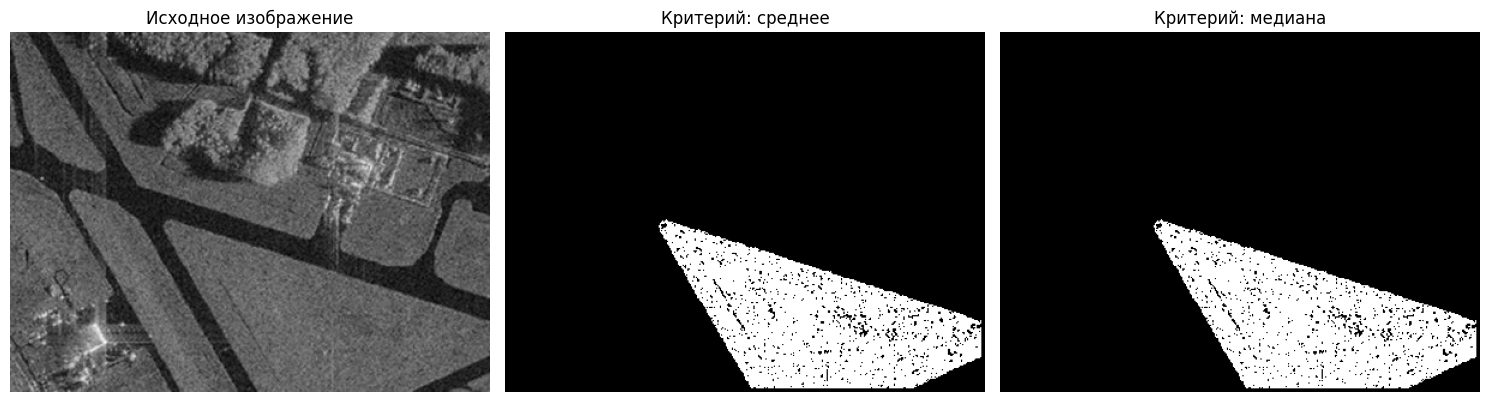

Сравнение результатов:
Размер области (среднее): 19307 пикселей
Размер области (медиана): 19356 пикселей
Разница в размере: 49 пикселей


In [10]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import copy

image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def homo_average(img, mask, point, T):
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0])                                       
    if abs(av_val - img[point]) <= T:
        return True
    return False

# Новый критерий на основе медианы
def homo_median(img, mask, point, T):
    if np.count_nonzero(mask) == 0:
        return False
    
    median_val = np.median(img[mask > 0])
    
    if abs(median_val - img[point]) <= T:
        return True
    return False

def region_growing(image, seed_point, homo_fun, r, T):
    mask = np.zeros(image.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    
    while count > 0:
        count = 0
        local_mask = np.zeros(image.shape, np.uint8)
        
        for i in range(r, image.shape[0] - r):
            for j in range(r, image.shape[1] - r):
                if mask[i, j] == 0 and mask[i - r:i + r, j - r:j + r].sum() > 0:
                    if homo_fun(image, mask, (i, j), T):
                        local_mask[i, j] = 1
                        count += 1
        
        mask += local_mask
    
    return mask * 255

seed_point = (250, 250)
r = 3
T = 15

# Сравнение двух критериев
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Исходное изображение
axes[0].imshow(image_gray, cmap="gray")
axes[0].set_title("Исходное изображение")
axes[0].axis('off')

# Критерий на основе среднего
mask_average = region_growing(image_gray, seed_point, homo_average, r, T)
axes[1].imshow(mask_average, cmap="gray")
axes[1].set_title("Критерий: среднее")
axes[1].axis('off')

# Критерий на основе медианы
mask_median = region_growing(image_gray, seed_point, homo_median, r, T)
axes[2].imshow(mask_median, cmap="gray")
axes[2].set_title("Критерий: медиана")
axes[2].axis('off')

plt.tight_layout()
plt.show()

# Сравнение статистик
print("Сравнение результатов:")
print(f"Размер области (среднее): {np.count_nonzero(mask_average)} пикселей")
print(f"Размер области (медиана): {np.count_nonzero(mask_median)} пикселей")
print(f"Разница в размере: {abs(np.count_nonzero(mask_average) - np.count_nonzero(mask_median))} пикселей")

Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев.

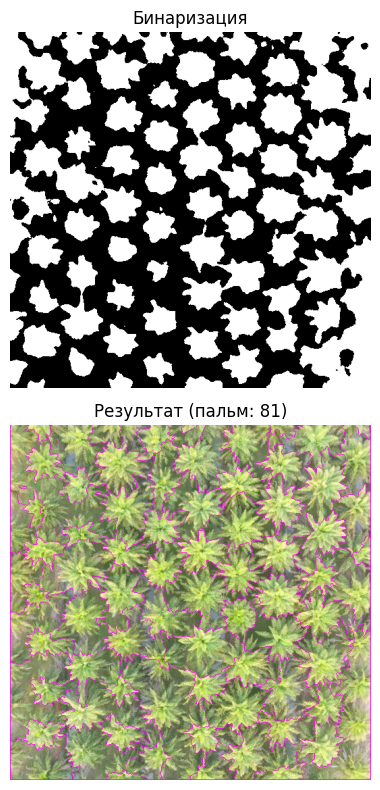

Количество пальм: 81


In [31]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Загрузка и подготовка изображения
image = cv2.imread("palm_1.JPG")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Предобработка
blurred = cv2.bilateralFilter(gray, 15, 150, 150)
_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Distance Transform
dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5)

# Создание маркеров
ret, sure_fg = cv2.threshold(dist, 0.25 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)

# Улучшение маркеров
kernel = np.ones((3, 3), np.uint8)
sure_fg = cv2.morphologyEx(sure_fg, cv2.MORPH_OPEN, kernel)

# Watershed сегментация
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers.astype(np.int32)
markers = cv2.watershed(image_rgb, markers)

# Подсчет пальм
num_palms = ret - 1

# Визуализация результатов
result_image = image_rgb.copy()
result_image[markers == -1] = [255, 0, 255]  # Границы сегментов

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 2)
plt.imshow(thresh, cmap='gray')
plt.title("Бинаризация")
plt.axis('off')

plt.subplot(2, 2, 4)
plt.imshow(result_image)
plt.title(f"Результат (пальм: {num_palms})")
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"Количество пальм: {num_palms}")
